# Flower Classifier - Transfer Learning

In [84]:
import numpy as np
import os 
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tsds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
print(tf.__version__)

2.3.0


# Download flowers dataset

In [ ]:
import pathlib
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


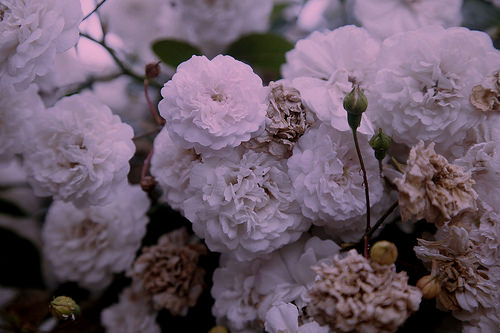

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[2]))

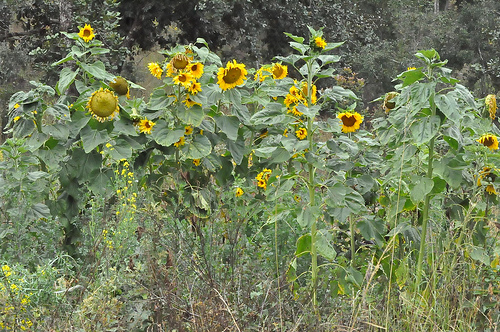

In [ ]:
roses = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(roses[2]))

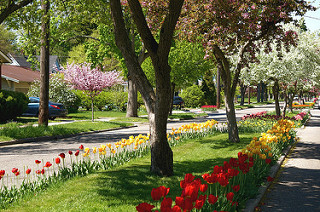

In [ ]:
roses = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(roses[2]))

## Load images using keras.preprocessing

Keras preprocessing is at the moment an experimental utility.

### Create a dataset

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

We use 80% of data for training and 20% for testing / validation.

In [ ]:
# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
# Testing /  Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# Print the class names
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data
We plot 12 images from the training dataset.

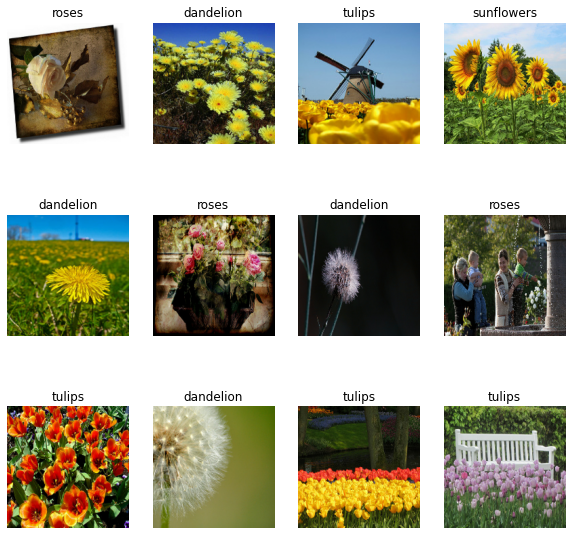

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

# (32, 180, 180, 3)
# batch of 32 images of shape 180x180x3

(32, 180, 180, 3)
(32,)


### Standardaze the data

In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

After normalization, pixels value is between 0 and 1.

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.96902645


### Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create a model
Source: https://www.tensorflow.org/tutorials/images/classification

3 convolution blocks with a max pool layer in each of them. The last layer is fully connected with 128 units.

In [ ]:
num_classes = 5

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## Compile the model

We will be using Adam optimizer and Sparse Categorical Crossentropy loss function.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

## Train model

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 3s 36ms/step - loss: 1.3220 - accuracy: 0.4445 - val_loss: 1.1602 - val_accuracy: 0.5381
Epoch 2/10
92/92 [==============================] - 2s 19ms/step - loss: 1.0142 - accuracy: 0.6012 - val_loss: 0.9878 - val_accuracy: 0.5981
Epoch 3/10
92/92 [==============================] - 2s 19ms/step - loss: 0.8044 - accuracy: 0.6911 - val_loss: 0.9775 - val_accuracy: 0.6144
Epoch 4/10
92/92 [==============================] - 2s 19ms/step - loss: 0.6270 - accuracy: 0.7677 - val_loss: 0.9648 - val_accuracy: 0.6403
Epoch 5/10
92/92 [==============================] - 2s 19ms/step - loss: 0.4030 - accuracy: 0.8556 - val_loss: 1.0915 - val_accuracy: 0.6240
Epoch 6/10
92/92 [==============================] - 2s 19ms/step - loss: 0.2347 - accuracy: 0.9271 - val_loss: 1.1985 - val_accuracy: 0.6744
Epoch 7/10
92/92 [==============================] - 2s 19ms/step - loss: 0.1351 - accuracy: 0.9615 - val_loss: 1.2963 - val_accuracy: 0.6431
Epoch 8/10
92

## Visualize training results
Plot loss and accuracy on the trainig and validation sets.

In [ ]:
def plot_model(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation / Testing Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation / Testing Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation / Testing Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation / Testing Loss')
  plt.show()

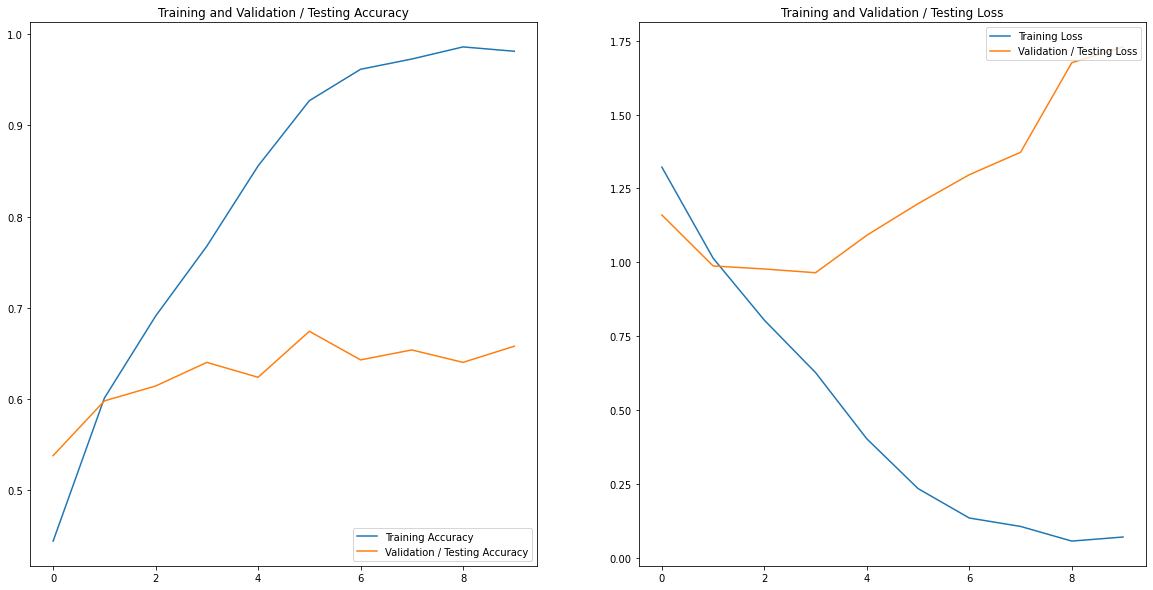

In [ ]:
plot_model(history)

# Overfitting

The training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. 

The difference in accuracy between training and validation accuracy is a sign of **overfitting** as result of a small number of training examples.

# Improve the model

## 1. Data augmentation
Generate additional training data from the existing examples by augmenting them using random transformations that yield believable-looking images.

It helps to expose the model to more aspects of the data and generalize better.

In [ ]:
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal',
                                               input_shape=(img_height,
                                                            img_width,
                                                            3)),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
])

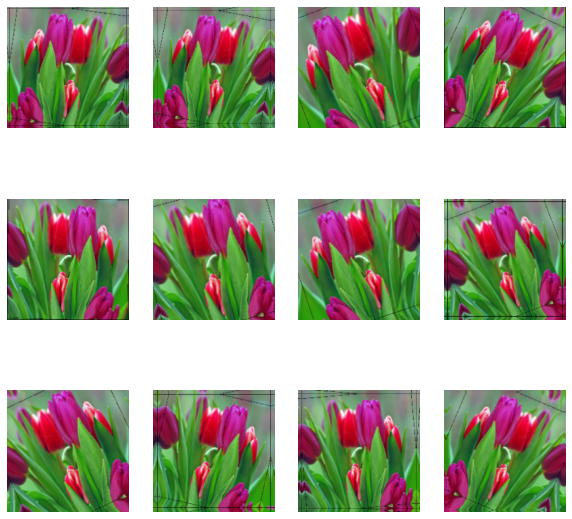

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(12):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis('off')

## Dropout
It randomly drops out (by setting the activation to zero) a number of ouput units from the layer during the training process.

In [ ]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# Compile and train the enhanced model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
epochs = 15
history_enhanced = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 3s 28ms/step - loss: 1.3042 - accuracy: 0.4401 - val_loss: 1.0987 - val_accuracy: 0.5613
Epoch 2/15
92/92 [==============================] - 2s 26ms/step - loss: 1.0028 - accuracy: 0.6049 - val_loss: 0.9785 - val_accuracy: 0.6063
Epoch 3/15
92/92 [==============================] - 2s 26ms/step - loss: 0.9195 - accuracy: 0.6390 - val_loss: 0.9027 - val_accuracy: 0.6553
Epoch 4/15
92/92 [==============================] - 2s 26ms/step - loss: 0.8457 - accuracy: 0.6802 - val_loss: 0.8429 - val_accuracy: 0.6689
Epoch 5/15
92/92 [==============================] - 2s 26ms/step - loss: 0.7855 - accuracy: 0.7016 - val_loss: 0.7857 - val_accuracy: 0.6839
Epoch 6/15
92/92 [==============================] - 2s 26ms/step - loss: 0.7443 - accuracy: 0.7142 - val_loss: 0.7407 - val_accuracy: 0.7153
Epoch 7/15
92/92 [==============================] - 2s 26ms/step - loss: 0.7003 - accuracy: 0.7337 - val_loss: 0.7290 - val_accuracy: 0.7248
Epoch 8/15
92

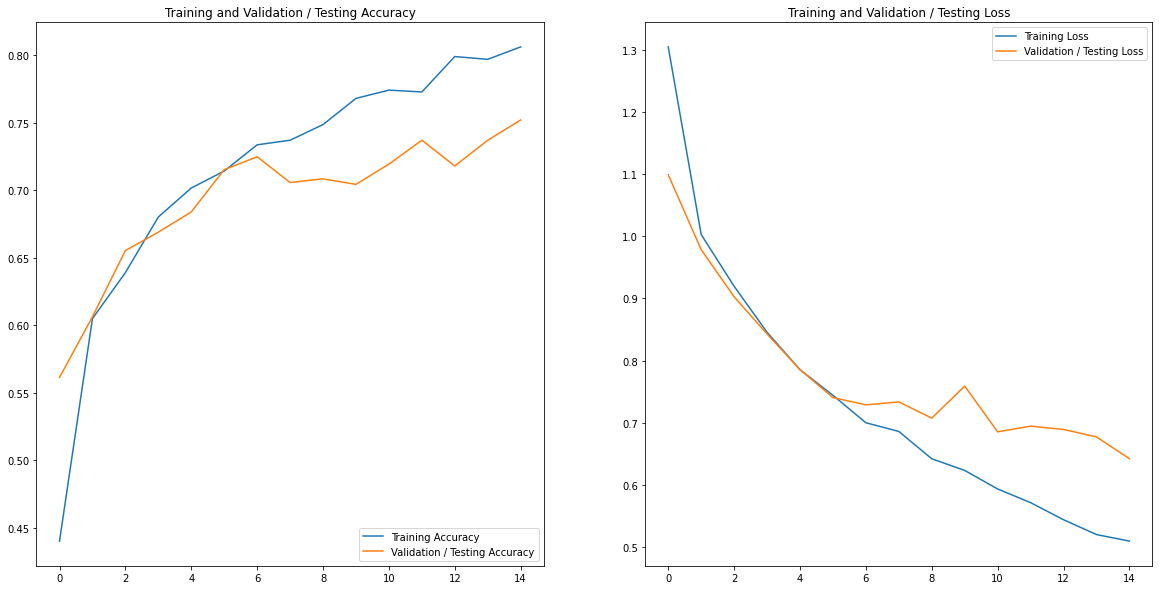

In [ ]:
plot_model(history_enhanced)

# Predict on new data

In [ ]:
sunflower_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
# Create a batch
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

predicted_class = class_names[np.argmax(score)]
predicted_percent = 100 * np.max(score)  

print(f'This image most likely belong to {predicted_class} with a {predicted_percent:.2f} percent confidence.')

This image most likely belong to sunflowers with a 99.78 percent confidence.


## Save the model 
/content/drive/MyDrive/Colab Notebooks/flower-classifier

In [85]:
save_path = '/content/drive/MyDrive/Colab Notebooks/flower-classifier'

In [86]:
model.save(save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/flower-classifier/assets


## Load the model back

In [87]:
loaded_model = keras.models.load_model(save_path)

### Try to predict again the same image on the loaded model

In [91]:
sunflower_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
# Create a batch
img_array = tf.expand_dims(img_array, 0)

predictions = loaded_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

predicted_class = class_names[np.argmax(score)]
predicted_percent = 100 * np.max(score)  

print(f'This image most likely belong to {predicted_class} with a {predicted_percent:.2f} percent confidence.')

This image most likely belong to sunflowers with a 99.78 percent confidence.
